In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
directory = os.getcwd()
data_all = pd.read_csv(directory + '/input_data.csv', sep=',') 

In [3]:
#all columns
data_all.head()

,INITIAL_SEVERITY_LEVEL_CODE,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,5,4,740.0,736.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,24,409.0,385.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,5,15,596.0,581.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,29,501.0,472.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,3,56,264.0,208.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


***INCLUDING IMPORTANT FEATURES ONLY***

In [4]:
data =data_all.drop(columns = 'DISPATCH_RESPONSE_SECONDS_QY')

In [5]:
#df without dispatch response seconds
data.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,5,740.0,736.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,409.0,385.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,5,596.0,581.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,501.0,472.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3,264.0,208.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
data.shape

(50000, 603)

***BINNING INCIDENT_TRAVEL_TM (DISCRETIZING)***

In [7]:
#bins; change n to change num of bins
n = 5 
max = 1025
bin_width = max/n #+1 because we have n bins so n+1 endpoints
bin_width

205.0

In [8]:
#bin ranges
bins = np.linspace(0,max,n+1)
bins

array([   0.,  205.,  410.,  615.,  820., 1025.])

In [9]:
#labels for bin ranges
labels = list(range(1,n+1))
labels

[1, 2, 3, 4, 5]

In [10]:
#df to visualize bins
df = pd.DataFrame(data = labels)
df['start'] = bins[:bins.shape[0]-1]
df['end'] = bins[1:]
df

,0,start,end
0,1,0.0,205.0
1,2,205.0,410.0
2,3,410.0,615.0
3,4,615.0,820.0
4,5,820.0,1025.0


In [11]:
#coding continuous data based on bins/labels, removing continuous data cols
data['INCIDENT_TRAVEL_TM_SECONDS_QY_Bin'] = pd.cut(data['INCIDENT_TRAVEL_TM_SECONDS_QY'],bins,labels=labels)
data = data.drop(columns = ['INCIDENT_TRAVEL_TM_SECONDS_QY'])
data.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,T7,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,INCIDENT_TRAVEL_TM_SECONDS_QY_Bin
0,5,740.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,4
1,2,409.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
2,5,596.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
3,1,501.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,3
4,3,264.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,2


In [12]:
import collections
from collections import Counter

In [13]:
travel_tm = collections.Counter(data["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
travel_tm_count = sum(travel_tm.values())
travel_tm

Counter({4: 5700, 2: 22025, 3: 14376, 5: 2210, 1: 5689})

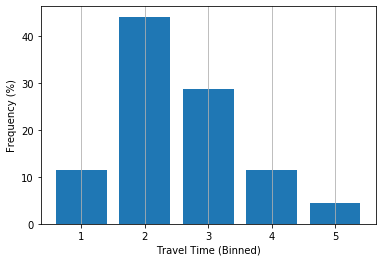

In [14]:
#visualize count of data within each bin
travel_tm = {k: (v*100) / travel_tm_count for k, v in travel_tm.items()} #mult by 100 to turn into percent
plt.bar(travel_tm.keys(),travel_tm.values())
plt.grid(axis = 'x')
plt.xlabel("Travel Time (Binned)")
plt.ylabel("Frequency (%)")
plt.show()

***SPLITTING TRAIN / TEST***

In [15]:
#X is predictors, Y is value to be predicted
X = data.drop(columns = ["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
Y = data["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"]

#splitting into training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

In [16]:
df_train = pd.concat([X_train,Y_train],axis = 1)
df_train.head()

,INITIAL_SEVERITY_LEVEL_CODE,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,T0,T1,T3,T4,T5,T6,T7,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,INCIDENT_TRAVEL_TM_SECONDS_QY_Bin
16207,5,625.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3
47394,2,166.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
9452,6,571.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
3308,6,802.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4
14128,5,429.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3


In [17]:
df_train.shape

(37500, 603)

***LINEAR DISCRIMINANT ANALYSIS***

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [19]:
#default parameters, shrinkage does not apply to SVD
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [20]:
lda.score(X_train,Y_train)

0.94472

In [21]:
lda.score(X_test,Y_test)

0.93712

In [22]:
Y_lda_predict = lda.predict(X_test)
Y_lda_predict

array([2, 3, 3, ..., 2, 2, 1])

In [23]:
print("=== Classification Report ===")
print(classification_report(Y_test, Y_lda_predict))

=== Classification Report ===
              precision    recall  f1-score   support

           1       0.93      0.90      0.91      1436
           2       0.94      0.95      0.95      5557
           3       0.93      0.93      0.93      3529
           4       0.93      0.92      0.93      1411
           5       0.96      0.94      0.95       567

    accuracy                           0.94     12500
   macro avg       0.94      0.93      0.93     12500
weighted avg       0.94      0.94      0.94     12500



In [24]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, Y_lda_predict))

=== Confusion Matrix ===
[[1294  142    0    0    0]
 [ 103 5305  149    0    0]
 [   0  182 3288   59    0]
 [   0    0   90 1296   25]
 [   0    0    0   36  531]]


***HYPERPARAMETER TUNING***

**Solver:** SVD (default), least squares

**Shrinkage:** none (default), 'auto' (only lsqr), float between 0 and 1

**tol:** threshold used to rank estimation in SVD solver

**SVD**

In [25]:
#run cross-validation on SVD model with different tol values for optimization
#run with 5 bins, 50k samples
from sklearn.model_selection import KFold


def lda(dataset, label_name, k, tols):
    # Code here
    cv = KFold(n_splits = k)
    scores = {}

    for train_index, test_index in cv.split(dataset):
        cv_train = dataset.iloc[train_index]
        cv_validate = dataset.iloc[test_index]
    
        for tol in tols:
            lda = LinearDiscriminantAnalysis(tol = tol)
            lda.fit(cv_train.drop([label_name], 1),cv_train[label_name])
            score = lda.score(cv_validate.drop([label_name],1),cv_validate[label_name])

            if tol in scores:
                scores[tol].append(score)
            else:
                scores[tol] = [score]
    

    return scores

In [26]:
#default 1e-4
tols = [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1]
tols

[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1]

In [27]:
#breaks at 10
scores = lda(df_train,'INCIDENT_TRAVEL_TM_SECONDS_QY_Bin',5,tols)

In [28]:
#tol 0.75 produces best results
scores

{1e-05: [0.9316,
  0.9362666666666667,
  0.9269333333333334,
  0.9304,
  0.9281333333333334],
 0.0001: [0.9316,
  0.9362666666666667,
  0.9269333333333334,
  0.9304,
  0.9281333333333334],
 0.001: [0.9316,
  0.9362666666666667,
  0.9269333333333334,
  0.9304,
  0.9281333333333334],
 0.01: [0.9316, 0.9364, 0.9269333333333334, 0.9304, 0.9284],
 0.1: [0.9428, 0.9437333333333333, 0.9366666666666666, 0.9376, 0.9384],
 0.5: [0.9436,
  0.9434666666666667,
  0.9388,
  0.9386666666666666,
  0.9406666666666667],
 0.75: [0.9450666666666667,
  0.9453333333333334,
  0.94,
  0.9404,
  0.9402666666666667],
 1: [0.4341333333333333,
  0.4396,
  0.436,
  0.4338666666666667,
  0.45213333333333333]}

In [29]:
avg_tol ={}
for k, v in scores.items():
    avg_tol[k] = sum(v)/float(len(v))
    
avg_tol

{1e-05: 0.9306666666666666,
 0.0001: 0.9306666666666666,
 0.001: 0.9306666666666666,
 0.01: 0.9307466666666666,
 0.1: 0.9398399999999999,
 0.5: 0.9410400000000001,
 0.75: 0.9422133333333333,
 1: 0.43914666666666663}

In [30]:
lists = sorted(avg_tol.items())
x,y = zip(*lists)

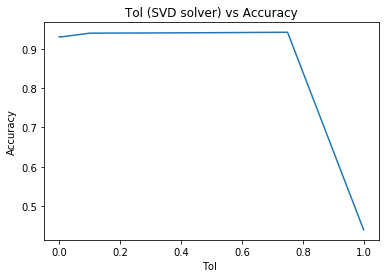

In [31]:
plt.plot(x,y)
plt.xlabel("Tol ")
plt.ylabel("Accuracy")
plt.title("Tol (SVD solver) vs Accuracy")
plt.show()

In [41]:
#run SVD with optimized tol # on all bin sizes
lda_svd = []
num_bins = [5, 12, 25, 41]

for n in num_bins:
    
    max = 1025
    bin_width = max/n

    bins = np.linspace(0,max,n+1)
    labels = list(range(1,n+1))
    
    data =data_all.drop(columns = 'DISPATCH_RESPONSE_SECONDS_QY')
    data['INCIDENT_TRAVEL_TM_SECONDS_QY_Bin'] = pd.cut(data['INCIDENT_TRAVEL_TM_SECONDS_QY'],bins,labels=labels)
    data = data.drop(columns = ['INCIDENT_TRAVEL_TM_SECONDS_QY'])
    
    ##REPLACE STRING DEFINING MODEL BELOW##


    X = data.drop(columns = ["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
    Y = data["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

    ## REPLACE MODEL below ##

    lda = LinearDiscriminantAnalysis(tol = 0.75)
    lda.fit(X_train,Y_train)

    score = lda.score(X_test,Y_test)

    ## REPLACE MODEL above ##

    lda_svd.append(score)

In [42]:
lda_svd

[0.94376, 0.86784, 0.73632, 0.5996]

**LSQR**

In [39]:
#run lsqr with NO shrinkage on all bin sizes
lda_lsqr = []
num_bins = [5, 12, 25, 41]

for n in num_bins:
    
    max = 1025
    bin_width = max/n

    bins = np.linspace(0,max,n+1)
    labels = list(range(1,n+1))
    
    data =data_all.drop(columns = 'DISPATCH_RESPONSE_SECONDS_QY')
    data['INCIDENT_TRAVEL_TM_SECONDS_QY_Bin'] = pd.cut(data['INCIDENT_TRAVEL_TM_SECONDS_QY'],bins,labels=labels)
    data = data.drop(columns = ['INCIDENT_TRAVEL_TM_SECONDS_QY'])
    
    ##REPLACE STRING DEFINING MODEL BELOW##

    X = data.drop(columns = ["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
    Y = data["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

    ## REPLACE MODEL below ##

    lda = LinearDiscriminantAnalysis(solver = 'lsqr')
    lda.fit(X_train,Y_train)

    score = lda.score(X_test,Y_test)

    ## REPLACE MODEL above ##

    lda_lsqr.append(score)

In [40]:
lda_lsqr

[0.93416, 0.85976, 0.71264, 0.54504]

In [36]:
#run lsqr with shrinkage on all bin sizes
lda_lsqr_shrink = []
num_bins = [5, 12, 25, 41]

for n in num_bins:
    
    max = 1025
    bin_width = max/n

    bins = np.linspace(0,max,n+1)
    labels = list(range(1,n+1))
    
    data =data_all.drop(columns = 'DISPATCH_RESPONSE_SECONDS_QY')
    data['INCIDENT_TRAVEL_TM_SECONDS_QY_Bin'] = pd.cut(data['INCIDENT_TRAVEL_TM_SECONDS_QY'],bins,labels=labels)
    data = data.drop(columns = ['INCIDENT_TRAVEL_TM_SECONDS_QY'])
    
    ##REPLACE STRING DEFINING MODEL BELOW##
    

    X = data.drop(columns = ["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
    Y = data["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

    ## REPLACE MODEL below ##

    lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto')
    lda.fit(X_train,Y_train)

    score = lda.score(X_test,Y_test)

    ## REPLACE MODEL above ##

    lda_lsqr_shrink.append(score)

In [37]:
#with shrinkage is slightly better than without
lda_lsqr_shrink

[0.938, 0.86752, 0.72408, 0.57736]

In [46]:
frames = [lda_svd, lda_lsqr, lda_lsqr_shrink]

In [51]:
solver_compare = pd.DataFrame(frames,columns = [5,12,25,41])
solver_compare.rename(index={0:"SVD",1:"LSQR",2:"LSQR (with shrinkage)"}, inplace = True)

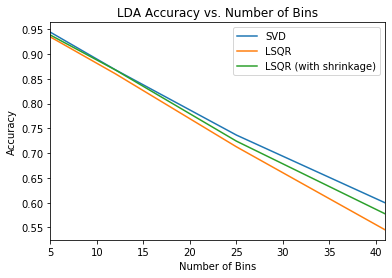

In [57]:
#svd performs the best
solver_compare.transpose().plot()
plt.xlabel("Number of Bins")
plt.ylabel("Accuracy")
plt.title("LDA Accuracy vs. Number of Bins")
plt.show()

***Sample Size vs. Score***

In [58]:
np.random.seed(2019)

In [59]:
directory = os.getcwd()
data_all = pd.read_csv(directory + '/input_data.csv', sep=',')

In [60]:
## REPLACE THIS WITH MY EXECUTED DICT AND NEW MODEL NAMES+BIN ##
summary_dict = {"LDA5":[],"LDA12":[],"LDA25":[],"LDA41":[],}

In [61]:
num_bins = [5, 12, 25, 41]
samplesize = [1000, 5000, 10000, 25000, 50000]

for n in num_bins:
    
    max = 1025
    bin_width = max/n

    bins = np.linspace(0,max,n+1)
    labels = list(range(1,n+1))
    
    data =data_all.drop(columns = 'DISPATCH_RESPONSE_SECONDS_QY')
    data['INCIDENT_TRAVEL_TM_SECONDS_QY_Bin'] = pd.cut(data['INCIDENT_TRAVEL_TM_SECONDS_QY'],bins,labels=labels)
    data = data.drop(columns = ['INCIDENT_TRAVEL_TM_SECONDS_QY'])
    
    ##REPLACE STRING DEFINING MODEL BELOW##
    row_label = 'LDA' + str(n)

    for s in samplesize:
    
        data_sampled = data.sample(n = s)
        
        X = data_sampled.drop(columns = ["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"])
        Y = data_sampled["INCIDENT_TRAVEL_TM_SECONDS_QY_Bin"]

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)
        
        ## REPLACE MODEL below ##
        
        lda = LinearDiscriminantAnalysis(solver = 'svd')
        lda.fit(X_train,Y_train)

        score = lda.score(X_test,Y_test)
                
        ## REPLACE MODEL above ##
        
        summary_dict[row_label].append(score)

In [71]:
summary_dict

{'LDA5': [0.708, 0.8592, 0.9012, 0.91856, 0.9356],
 'LDA12': [0.54, 0.7768, 0.8344, 0.86176, 0.86232],
 'LDA25': [0.364, 0.5856, 0.6528, 0.69136, 0.71176],
 'LDA41': [0.244, 0.3792, 0.4384, 0.50912, 0.5392]}

In [78]:
df = pd.DataFrame.from_dict(summary_dict,orient = 'index',columns = ['1K','5K','10K','25K','50K'])
df

,1K,5K,10K,25K,50K
LDA5,0.708,0.8592,0.9012,0.91856,0.93560
LDA12,0.540,0.7768,0.8344,0.86176,0.86232
LDA25,0.364,0.5856,0.6528,0.69136,0.71176
LDA41,0.244,0.3792,0.4384,0.50912,0.53920


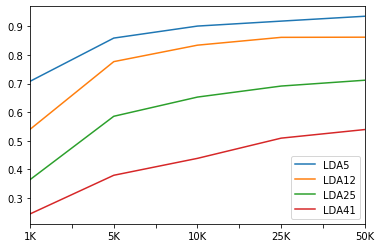

In [79]:
df.transpose().plot()